# Loan Default Risk Analysis
DS325 - Group Project: Analyzing Loan Risk 
 - Linh Vu & Linh Tran
 - This is the link to the data set: https://www.kaggle.com/datasets/wordsforthewise/lending-club/data)
 - This notebook presents a machine learning analysis to classify loan applicants as high or low risk, based on financial history and loan application data. The goal is to predict whether a borrower will 'Fully Pay' or 'Charge Off' their loan.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler



In [2]:
# Load selected features
use_cols = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
            'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
            'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'fico_range_low',
            'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec',
            'revol_bal', 'revol_util', 'total_acc']
df = pd.read_csv('accepted_2007_to_2018Q4.csv', usecols=use_cols)
df.columns = df.columns.str.strip()
df


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,3600.0,36 months,13.99,123.03,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,...,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0
1,24700.0,36 months,11.99,820.28,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,...,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0
2,20000.0,60 months,10.78,432.66,B,B4,10+ years,MORTGAGE,63000.0,Not Verified,...,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0
3,35000.0,60 months,14.85,829.90,C,C5,10+ years,MORTGAGE,110000.0,Source Verified,...,17.06,0.0,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0
4,10400.0,60 months,22.45,289.91,F,F1,3 years,MORTGAGE,104433.0,Source Verified,...,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,40000.0,60 months,10.49,859.56,B,B3,9 years,MORTGAGE,227000.0,Verified,...,12.75,7.0,705.0,709.0,1.0,5.0,0.0,8633.0,64.9,37.0
2260697,24000.0,60 months,14.49,564.56,C,C4,6 years,RENT,110000.0,Not Verified,...,18.30,0.0,660.0,664.0,0.0,10.0,1.0,17641.0,68.1,31.0
2260698,14000.0,60 months,14.49,329.33,C,C4,10+ years,MORTGAGE,95000.0,Verified,...,23.36,0.0,660.0,664.0,1.0,8.0,0.0,7662.0,54.0,22.0
2260699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Filter and preprocess target
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})
df = df.dropna(subset=['annual_inc', 'emp_length', 'dti', 'fico_range_low'])
df['term'] = df['term'].str.extract('(\d+)').astype(int)
df['emp_length'] = df['emp_length'].str.extract('(\d+)').fillna(0).astype(int)

/var/folders/fd/_pl5jrvj5wvfk80mn1w60wtr0000gn/T/ipykernel_44740/2252335376.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})


In [10]:
# Select and encode features
safe_cols = ['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade',
             'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
             'purpose', 'dti', 'fico_range_low', 'fico_range_high', 'inq_last_6mths']

X = pd.get_dummies(df[safe_cols])
y = df['loan_status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]


In [11]:
missing = X_train.isnull().sum()
print(missing[missing > 0])

Series([], dtype: int64)


In [12]:
# Fit model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89    204097
           1       0.47      0.09      0.15     49260

    accuracy                           0.80    253357
   macro avg       0.65      0.53      0.52    253357
weighted avg       0.75      0.80      0.75    253357



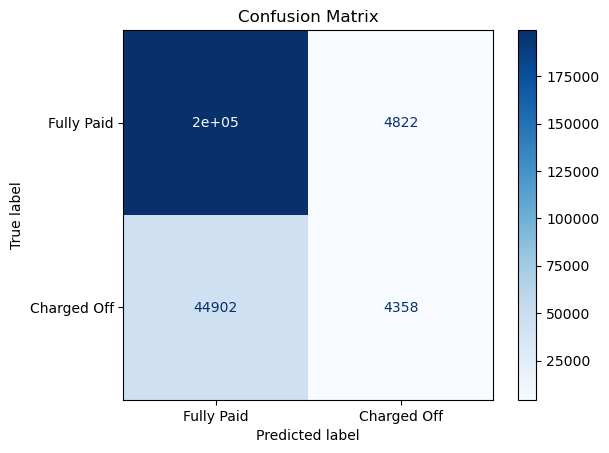

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fully Paid', 'Charged Off'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

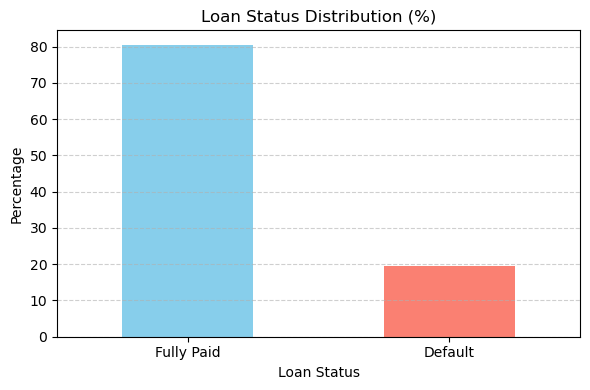

In [ ]:
# Visualize class imbalance

# Calculate distribution
loan_dist = df['loan_status'].value_counts(normalize=True) * 100

# Map numeric labels to string labels for plotting
label_map = {0: 'Fully Paid', 1: 'Default'}
loan_dist.index = loan_dist.index.map(label_map)

# Plot
plt.figure(figsize=(6, 4))
loan_dist.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Loan Status Distribution (%)')
plt.ylabel('Percentage')
plt.xlabel('Loan Status')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [15]:
df['loan_status'].value_counts(normalize=True) * 100

0    80.468147
1    19.531853
Name: loan_status, dtype: float64

Model right now is good at catching "fully-paid" but bad at catching "charged-off". Because most of cases are fully-paid but "charged-off" is rare.
=> SOLUTION: REBALANCE by one of these methods:
1. Classweightoff
2. Oversample the "charged-off" with SMOTE
3. Undersample the "fully-paid"

# Trouble-shooting: Classweight

In [16]:
# Fit model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight = 'balanced')
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89    204097
           1       0.48      0.08      0.13     49260

    accuracy                           0.80    253357
   macro avg       0.65      0.53      0.51    253357
weighted avg       0.75      0.80      0.74    253357



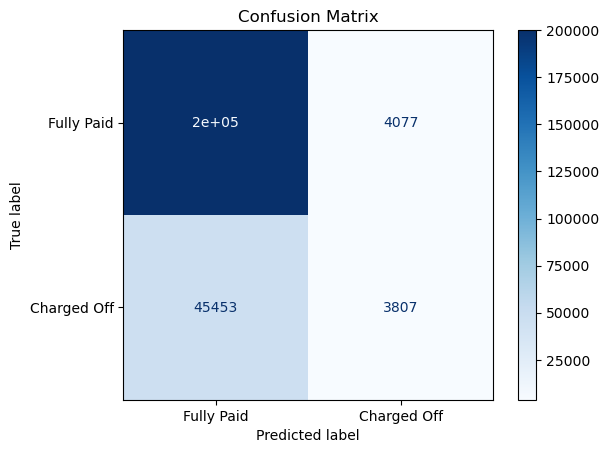

In [17]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fully Paid', 'Charged Off'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Trouble-shooting: Oversample "charged-off"

In [ ]:

smote = SMOTE(random_state=42)

In [20]:
#SMOTE oversampling
fsmote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
model = RandomForestClassifier(random_state=42)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)

In [21]:
model = RandomForestClassifier(random_state=42)
model.fit(X_res, y_res)

RandomForestClassifier(random_state=42)

In [22]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89    204097
           1       0.45      0.11      0.18     49260

    accuracy                           0.80    253357
   macro avg       0.63      0.54      0.53    253357
weighted avg       0.75      0.80      0.75    253357

[[197555   6542]
 [ 43908   5352]]


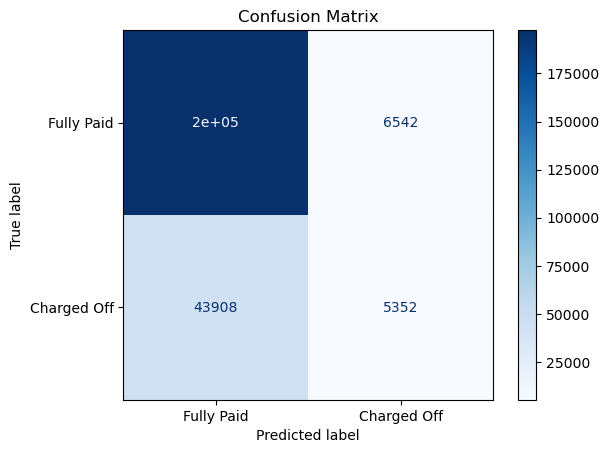

In [23]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fully Paid', 'Charged Off'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Trouble-shooting: Undersampling

In [34]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

In [35]:
model = RandomForestClassifier(random_state=42)
model.fit(X_res, y_res)

model = RandomForestClassifier(random_state=42)
model.fit(X_res, y_res)

RandomForestClassifier(random_state=42)

In [36]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
#ConfusionMatrixDisplay.from_estimator(model, X_test, y_test).plot()

              precision    recall  f1-score   support

           0       0.88      0.63      0.74    204097
           1       0.30      0.65      0.41     49260

    accuracy                           0.64    253357
   macro avg       0.59      0.64      0.58    253357
weighted avg       0.77      0.64      0.67    253357



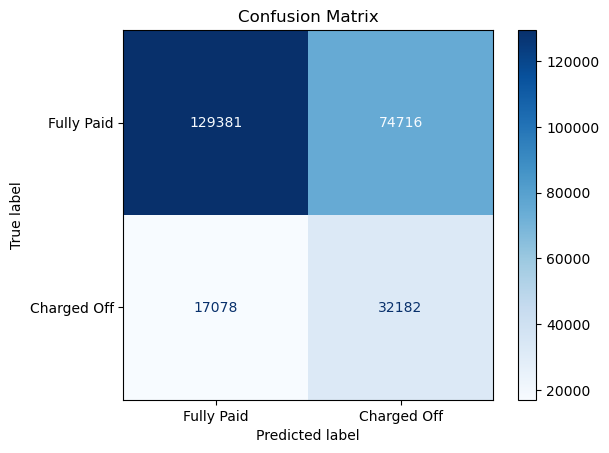

In [28]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fully Paid', 'Charged Off'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

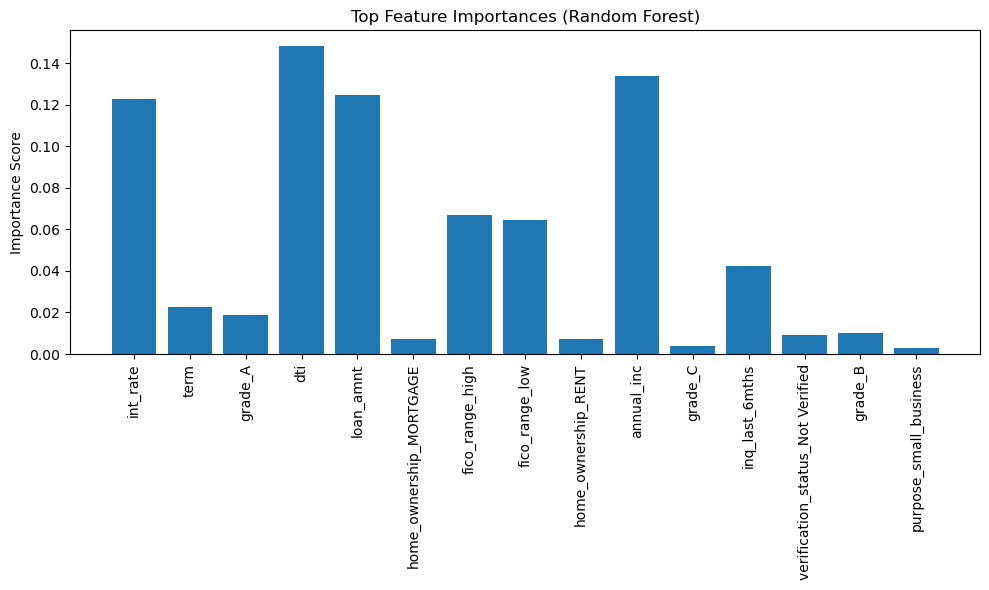

In [37]:
importances = model.feature_importances_  # model = your trained RandomForestClassifier
feature_names = X_train.columns
plt.figure(figsize=(10, 6))
plt.title("Top Feature Importances (Random Forest)")
plt.bar(range(top_n), importances[indices][:top_n], align="center")
plt.xticks(range(top_n), feature_names[indices][:top_n], rotation=90)
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# Gradient Boosting with manual class weights

📋 Classification Report (Gradient Boosting with Manual Imputation)
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    204097
           1       0.31      0.67      0.42     49260

    accuracy                           0.64    253357
   macro avg       0.60      0.65      0.58    253357
weighted avg       0.78      0.64      0.68    253357



Text(0.5, 1.0, 'Gradient Boosting Classifier')

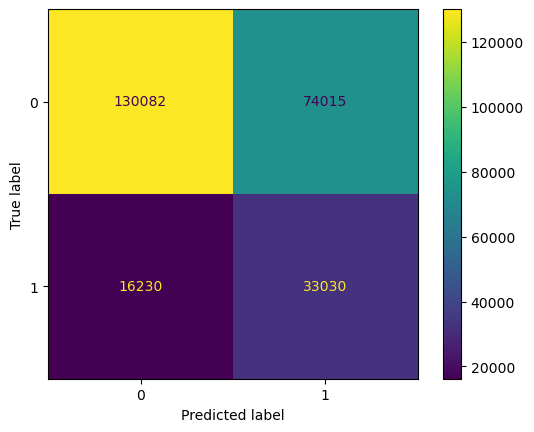

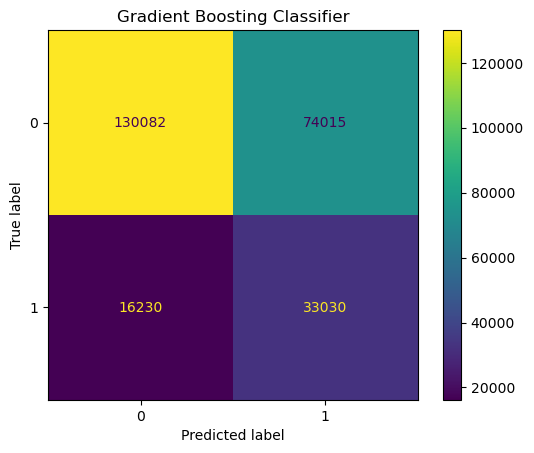

In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train_filled = X_train.fillna(X_train.mean())
X_test_filled = X_test.fillna(X_train.mean())  # Use training mean to fill test set

# Handle class imbalance with weights
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1 / np.sum(y_train == 0)
weights[y_train == 1] = 1 / np.sum(y_train == 1)

# Train the model
gbc = GradientBoostingClassifier()
gbc.fit(X_train_filled, y_train, sample_weight=weights)

# Predict and evaluate
y_pred = gbc.predict(X_test_filled)

print("Classification Report (Gradient Boosting with Manual Imputation)")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(gbc, X_test_filled, y_test).plot()
plt.title("Gradient Boosting Classifier")


In [ ]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1 / np.sum(y_train == 0)
weights[y_train == 1] = 1 / np.sum(y_train == 1)

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train, sample_weight=weights)

y_pred = gbc.predict(X_test)


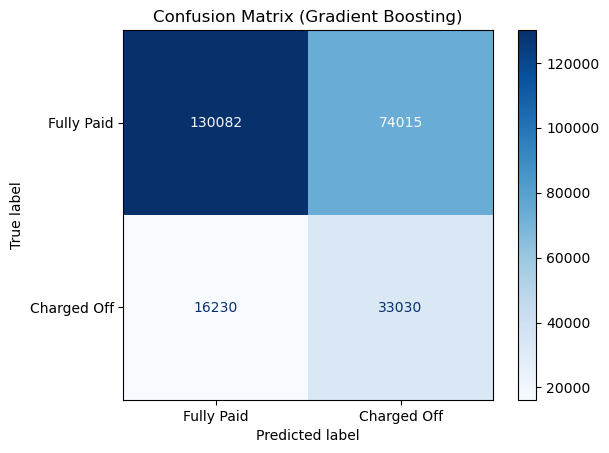

In [30]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fully Paid', 'Charged Off'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Gradient Boosting)')
plt.show()

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.64      0.74    204097
           1       0.31      0.67      0.42     49260

    accuracy                           0.64    253357
   macro avg       0.60      0.65      0.58    253357
weighted avg       0.78      0.64      0.68    253357



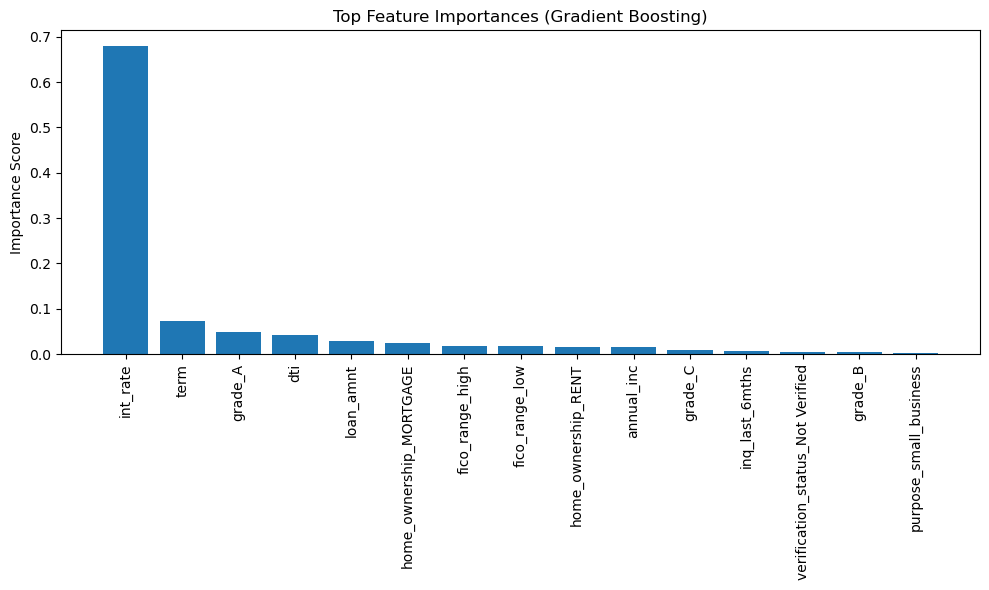

In [ ]:
importances = gbc.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(10, 6))
plt.title("Top Feature Importances (Gradient Boosting)")
plt.bar(range(top_n), importances[indices][:top_n], align="center")
plt.xticks(range(top_n), X_train.columns[indices][:top_n], rotation=90)
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [45]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pandas as pd

# Scale and convert to DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_train.columns)

# Add intercept
X_scaled_df = sm.add_constant(X_scaled_df)

# Align target index
y_train_aligned = y_train.reset_index(drop=True)

# Fit model
logit_model = sm.Logit(y_train_aligned, X_scaled_df)
result = logit_model.fit()

# Show results
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.449034
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:              1013424
Model:                          Logit   Df Residuals:                  1013360
Method:                           MLE   Df Model:                           63
Date:                Sun, 04 May 2025   Pseudo R-squ.:                 0.09132
Time:                        10:14:15   Log-Likelihood:            -4.5506e+05
converged:                       True   LL-Null:                   -5.0079e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -1.6182      0.003